In [1]:
import tensorflow as tf
print(tf.__version__)
from google.colab import drive
drive.mount('/content/drive')
!unzip "drive/MyDrive/AI_Datasets/Udacity_dataset.zip"
# Aceasta arhiva trebuie downloadata de la linkul de mai jos si pusa mai intai in google drive-ul personal
# https://drive.google.com/file/d/1TAV-36-ZQJ12ZFIPBDr1e0Uul5Po0hpr/view?usp=sharing

Streaming output truncated to the last 5000 lines.
  inflating: track2data/track2data/IMG/right_2019_04_02_18_25_14_348.jpg  
  inflating: track2data/track2data/IMG/right_2019_04_02_18_25_14_416.jpg  
  inflating: track2data/track2data/IMG/right_2019_04_02_18_25_14_483.jpg  
  inflating: track2data/track2data/IMG/right_2019_04_02_18_25_14_555.jpg  
  inflating: track2data/track2data/IMG/right_2019_04_02_18_25_14_623.jpg  
  inflating: track2data/track2data/IMG/right_2019_04_02_18_25_14_695.jpg  
  inflating: track2data/track2data/IMG/right_2019_04_02_18_25_14_764.jpg  
  inflating: track2data/track2data/IMG/right_2019_04_02_18_25_14_833.jpg  
  inflating: track2data/track2data/IMG/right_2019_04_02_18_25_14_907.jpg  
  inflating: track2data/track2data/IMG/right_2019_04_02_18_25_14_979.jpg  
  inflating: track2data/track2data/IMG/right_2019_04_02_18_25_15_048.jpg  
  inflating: track2data/track2data/IMG/right_2019_04_02_18_25_15_115.jpg  
  inflating: track2data/track2data/IMG/right_2019

In [2]:
import os
import time
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import tensorflow as tf
from google.colab.patches import cv2_imshow as imshow
from sklearn.model_selection import train_test_split

def my_imshow(img):#Normalizez valorile pixelilor intre 0 si 255
  min = np.min(img)
  max = np.max(img)
  img = 255*(img-min)/(max-min)
  imshow(img)

data_dir = "track1data/track1data/"
sep = "/"
sep_data = '\\' #separatorul folosit de Udacity in csv

In [3]:
df = pd.read_csv(os.path.join(data_dir, 'driving_log.csv'))
imgs_path = df.iloc[:, 0:3].values
steering = df.iloc[:, 3].values

In [4]:
p = imgs_path[0][0]
print(imgs_path[0][0])
p_sep = p.split(sep_data)
test_img = data_dir + "IMG" + sep + p_sep[-1]

Desktop\track1data\IMG\center_2019_04_02_19_25_33_743.jpg


(160, 320, 3)


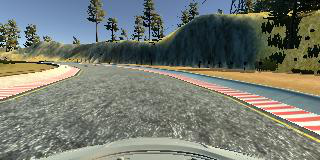

In [5]:
img = imread(test_img)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
print(img.shape)
imshow(img)

(66, 200, 3)


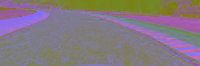

In [6]:
img = imread(test_img)
img = img[50:140]
dimx = 66
dimy = 200
img = cv2.resize(img, (dimy, dimx))
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
img = img/127.5 - 1.0
#img = cv2.flip(img, 1)

my_imshow(img)

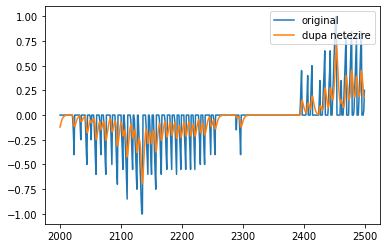

In [7]:
index = [i for i in range(0,len(steering))]
sns.lineplot(x=index[2000:2500],y=steering[2000:2500])

alpha = 0.4
smoothed_steering = [steering[0]]
last_s_prim = steering[0]
for i in range(1, len(steering)):
  s_prim = alpha * steering[i] + (1-alpha) * last_s_prim
  last_s_prim = s_prim
  smoothed_steering.append(alpha*s_prim + (1-alpha)*smoothed_steering[-1])
  # smoothed_steering.append(alpha*steering[i] + (1-alpha)*smoothed_steering[-1])
sns.lineplot(x=index[2000:2500],y=smoothed_steering[2000:2500])
plt.legend(['original', 'dupa netezire'], loc='upper right')

steering = np.array(smoothed_steering)

In [8]:
offset = 0.3
def process_img(img):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = img[50:140]
  img = cv2.resize(img, (dimy, dimx))
  img = img/127.5 - 1.0
  return img

imgs = []
for path in imgs_path:
  for p in path:
    p_sep = p.split(sep_data)
    real_path = data_dir + "IMG" + sep + p_sep[-1]
    img = imread(real_path)
    img = process_img(img)
    imgs.append(img)

steering_aux = []
for s in steering:
  steering_aux.append(s)
  steering_aux.append(s+offset)
  steering_aux.append(s-offset)

imgs = np.array(imgs)
steering = np.array(steering_aux)

In [9]:
imgs.shape

(31842, 66, 200, 3)

In [10]:
imgs_train, imgs_eval, labels_train, labels_eval = train_test_split(imgs, steering, test_size = 0.1, random_state = 0)
del imgs

In [11]:
labels_eval.shape

(3185,)

In [12]:
def img_shift(img):
    range = 80
    shift_x = range*np.random.uniform() - range/2
    M = np.float32([[1,0,shift_x],[0,1,0]])
    img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    adj = shift_x/60*offset
    return img, adj

class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, imgs, labels, b_size):
    self.x_data, self.y_data = imgs, labels
    self.b_size = b_size
    self.nr_batches = np.ceil(len(imgs) / b_size)
    self.batch_index = np.array_split(range(len(imgs)), self.nr_batches)

  def __len__(self):
    return len(self.batch_index)

  def __getitem__(self, index):
    batch_x = self.x_data[self.batch_index[index]]
    batch_y = self.y_data[self.batch_index[index]]
    batch_x, batch_y = self.augment_batch(batch_x, batch_y)
    return batch_x, batch_y

  def augment_batch(self, batch_x, batch_y):
    aug_batch_x = []
    aug_batch_y = []
    for x, y in zip(batch_x, batch_y):
      coin = random.randint(0, 1)
      if coin:
        aug_x, aug_y = self.augment_data(x, y)
        aug_batch_x.append(aug_x)
        aug_batch_y.append(aug_y)
      else:
        if random.randint(0, 1):
          dim_filtru = random.randint(1, 5)#Bluram imaginea
          if dim_filtru % 2 != 1:
              dim_filtru += 1
          img = cv2.GaussianBlur(img, (dim_filtru, dim_filtru), 0)
        aug_batch_x.append(x)
        aug_batch_y.append(y)
    return np.array(aug_batch_x), np.array(aug_batch_y)

  def augment_data(self, x, y):
    choose_augment = random.randint(0, 3)
    if choose_augment <= 1:
      x = cv2.flip(x, 1)
      y = -y
    if choose_augment == 2:
      img, adj = img_shift(x)
      y = y + adj
    return x, y

In [21]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout

In [22]:
def NVIDIA_model():
  model = Sequential()
  model.add(Conv2D(24, kernel_size=(5, 5), strides = (2, 2), input_shape=(dimx, dimy, 3)))
  model.add(tf.keras.activations.elu())
  model.add(Conv2D(36, kernel_size=(5, 5), strides = (2, 2)))
  model.add(tf.keras.activations.elu())
  model.add(Conv2D(48, kernel_size=(3, 3)))
  model.add(tf.keras.activations.elu())
  model.add(Conv2D(48, kernel_size=(5, 5)))
  model.add(tf.keras.activations.elu())
  model.add(Conv2D(64, kernel_size=(3, 3)))  
  model.add(tf.keras.activations.elu())
  model.add(Conv2D(64, kernel_size=(3, 3)))
  model.add(tf.keras.activations.elu())
  model.add(Dropout(0.1))
  model.add(Flatten())
  model.add(Dense(100))
  model.add(tf.keras.activations.elu())
  model.add(Dense(50))
  model.add(tf.keras.activations.elu())
  model.add(Dense(10))
  model.add(tf.keras.activations.elu())
  model.add(Dense(1))
  model.build()
  model.summary()
  
  return model

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=1,
                              min_lr=0.00001)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=3,
                           restore_best_weights=True)

b_size = 16
train_generator = DataGenerator(imgs_train, labels_train, b_size = b_size)
Adam = tf.keras.optimizers.Adam
model = NVIDIA_model()
model.compile(optimizer = Adam(lr = 0.0001),
              loss = 'mean_squared_error')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_14 (Conv2D)          (None, 12, 45, 48)        15600     
                                                                 
 conv2d_15 (Conv2D)          (None, 8, 41, 48)         57648     
                                                                 
 conv2d_16 (Conv2D)          (None, 6, 39, 64)         27712     
                                                                 
 conv2d_17 (Conv2D)          (None, 4, 37, 64)         36928     
                                                                 
 dropout (Dropout)           (None, 4, 37, 64)        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [24]:
history = model.fit(train_generator,
                    epochs = 10,
                    validation_data = (imgs_eval, labels_eval),
                    callbacks = [reduce_lr, early_stop])

Epoch 1/10
1792/1792 [==============================] - 16s 9ms/step - loss: 0.0271 - val_loss: 0.0074 - lr: 1.0000e-04
Epoch 2/10
1792/1792 [==============================] - 13s 7ms/step - loss: 0.0084 - val_loss: 0.0057 - lr: 1.0000e-04
Epoch 3/10
1792/1792 [==============================] - 13s 7ms/step - loss: 0.0070 - val_loss: 0.0048 - lr: 1.0000e-04
Epoch 4/10
1792/1792 [==============================] - 13s 7ms/step - loss: 0.0064 - val_loss: 0.0044 - lr: 1.0000e-04
Epoch 5/10
1792/1792 [==============================] - 13s 7ms/step - loss: 0.0058 - val_loss: 0.0045 - lr: 1.0000e-04
Epoch 6/10
1792/1792 [==============================] - 13s 7ms/step - loss: 0.0050 - val_loss: 0.0038 - lr: 5.0000e-05
Epoch 7/10
1792/1792 [==============================] - 13s 7ms/step - loss: 0.0048 - val_loss: 0.0041 - lr: 5.0000e-05
Epoch 8/10
1792/1792 [==============================] - 13s 7ms/step - loss: 0.0044 - val_loss: 0.0037 - lr: 2.5000e-05
Epoch 9/10
1792/1792 [==================

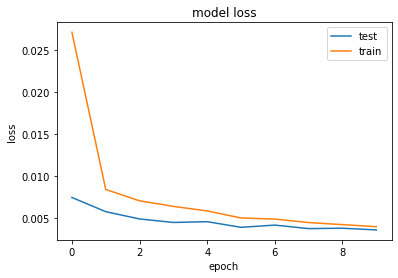

In [25]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['test', 'train'], loc='upper right')
plt.show()

In [26]:
predictions = model.predict(imgs_eval)

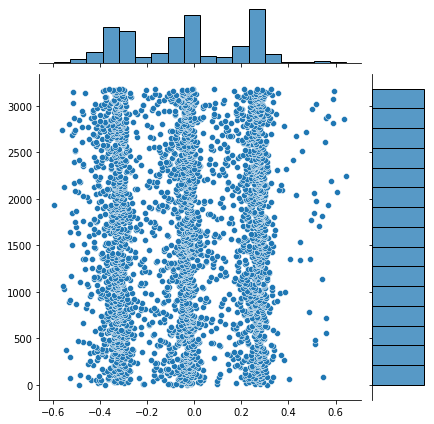

In [27]:
index = [i for i in range(0,len(labels_eval))]
sns.jointplot(x=predictions.transpose()[0],y=index)

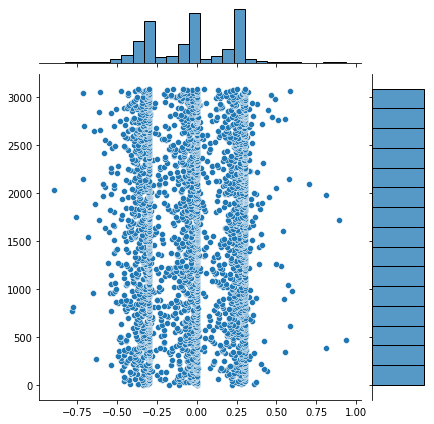

In [28]:
index = [i for i in range(0,len(labels_eval[100:]))]
sns.jointplot(x=labels_eval[100:],y=index)

In [29]:
model.save('model.h5')